In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import external libraries

In [2]:
import torch
import numpy as np
import scipy.signal
import tensorly as tl
import matplotlib.pyplot as plt

import gc

import internal libraries

In [3]:
import sys
sys.path.append(r'/media/rich/Home_Linux_partition/github_repos')

%load_ext autoreload
%autoreload 2
import basic_neural_processing_modules as bnpm
from basic_neural_processing_modules import torch_helpers, h5_handling, timeSeries, similarity, math_functions, misc, decomposition, linear_regression, pickle_helpers

make synthetic latents

In [171]:
X_dims_fake = [5000, 20000]
dtype = torch.float32

latents = [
          torch.vstack([torch.sin(torch.linspace(0, 140, X_dims_fake[0]))*50,
                        torch.cos(torch.linspace(2,19,X_dims_fake[0]))*10,
                        torch.linspace(0,1,X_dims_fake[0])*2,
                        torch.cos(torch.linspace(0,17,X_dims_fake[0])) >0]).T*0.4,
          torch.tensor(scipy.signal.savgol_filter(np.random.rand(X_dims_fake[1], 4), 15, 3, axis=0))-0.5,
        ]

for ii, latent in enumerate(latents):
    latents[ii] = latent.type(dtype)
    

mix latents into data

In [172]:
data_mix = torch.einsum('ij,jk->ik', latents[0], latents[1].T).T

print('data_mix size:')
torch_helpers.tensor_sizeOnDisk(data_mix);

data_mix size:
Device: cpu, Shape: torch.Size([20000, 5000]), Size: 0.4 GB


show latents and mixed data

<IPython.core.display.Javascript object>


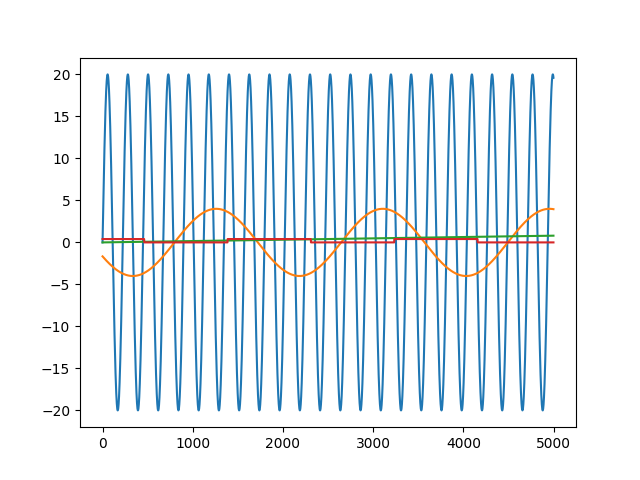

<IPython.core.display.Javascript object>


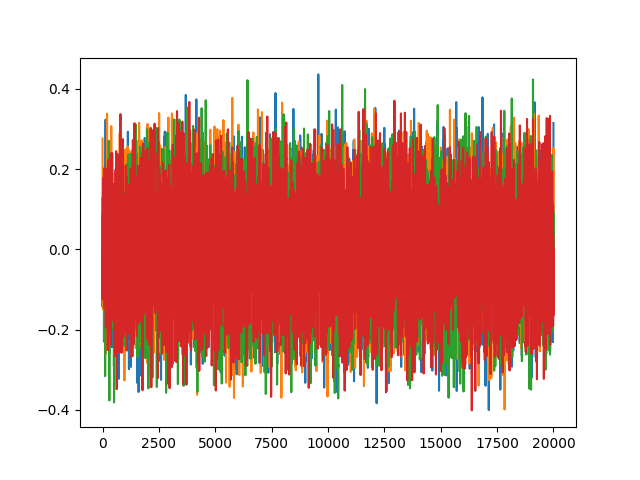

<IPython.core.display.Javascript object>


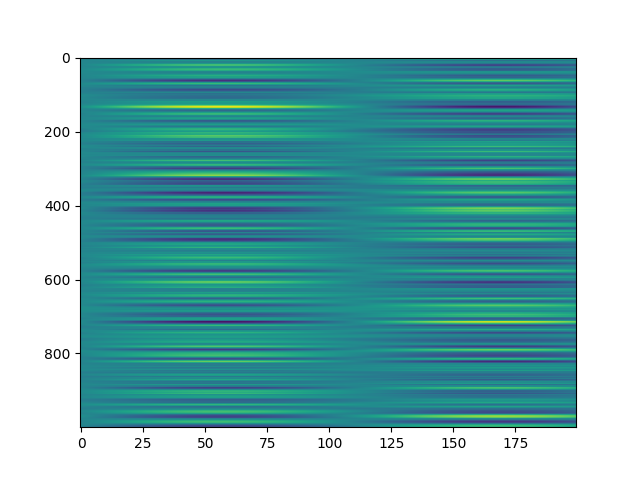

In [173]:
plt.figure()
plt.plot(latents[0])

plt.figure()
plt.plot(latents[1])

plt.figure()
plt.imshow(data_mix[:1000,:200], aspect='auto')

do PCA

In [174]:
DEVICE = torch_helpers.set_device(use_GPU=True, verbose=False)
components, scores, singVals, EVR = decomposition.torch_pca(X,
                                                               device=DEVICE,
                                                               mean_sub=True,
                                                               zscore=False,
                                                               rank=data_mix.shape[1],
                                                               return_cpu=True,
                                                               return_numpy=False)

In [175]:
components.shape

torch.Size([5000, 5000])

In [176]:
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

plot PCs

<IPython.core.display.Javascript object>


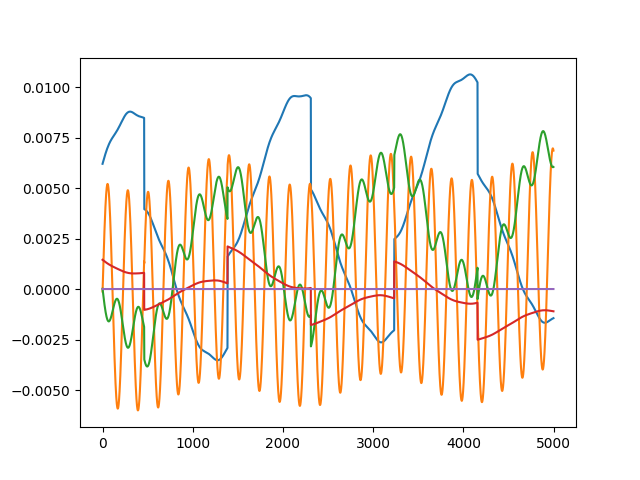

<IPython.core.display.Javascript object>


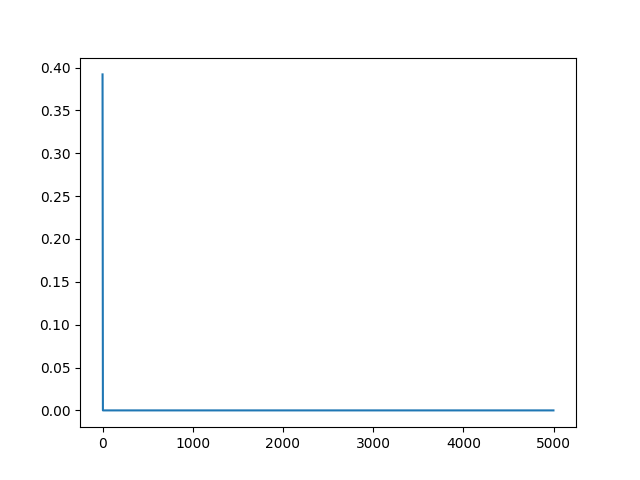

In [177]:
plt.figure()
plt.plot(components[:,:5] * EVR[:5])

plt.figure()
plt.plot(EVR)

In [178]:
import copy
from tqdm.notebook import tqdm

In [179]:
DEVICE = torch_helpers.set_device(use_GPU=True)

device: 'cuda'


In [180]:
X = torch.as_tensor(data_mix, dtype=torch.float32, device=DEVICE)
n_batches=7
pcs_per_batch = 2500
rank_final = 20

In [181]:
X_idx = np.arange(X.shape[0])
l = X.shape[0]
r = n_batches-l%n_batches # remainder
test_rp = np.random.permutation(X_idx)
test_pad = np.concatenate((test_rp,[np.nan]*r))
batches = test_pad.reshape(n_batches,-1)
batch_idx_all = [[np.int64(batch[~np.isnan(batch)])] for batch in batches]

In [182]:
T, N = data_mix.shape

# giant U that we will fill up with smaller SVDs
U_all = torch.zeros((N, n_batches * pcs_per_batch), dtype=torch.float32, device=DEVICE)
X_mean = torch.mean(X[batch_idx_all[0]], dim=0, keepdims=True)

for iter_batch, batch_idx in enumerate(tqdm(batch_idx_all, "Computing SVD")):
    batch = X[batch_idx]
    batch -= X_mean

#         im = np.abs(np.diff(im, axis=-1))
#         im = np.reshape(im, (Lyb * Lxb, -1))

#         # subtract off average motion
#         im -= avgmotion.flatten()[:, np.newaxis]

    # take SVD
#         usv = svdecon(im, k=pcs_per_chunk)
#         rank = batch.shape[1]
    rank = pcs_per_batch
    (U,S,V) = torch.pca_lowrank(batch.T, q=rank, center=False, niter=2)


    U_all[:, iter_batch * pcs_per_batch:(iter_batch + 1) * pcs_per_batch] = U

# take SVD of concatenated spatial PCs
#     USV = svdecon(U, k=ncomps)
rank = np.minimum(U_all.shape[1], U_all.shape[0])
(U,S,V) = torch.pca_lowrank(U_all, q=rank, center=False, niter=2)

X_projected = torch.zeros(X.shape[0], rank_final, device=DEVICE)
for iter_batch, batch_idx in enumerate(tqdm(batch_idx_all, "Projecting SVD")):
    batch = X[batch_idx]
    batch -= X_mean
    
    X_projected[batch_idx] = (batch @ U)[:,:rank_final]

Computing SVD:   0%|          | 0/7 [00:00<?, ?it/s]

Projecting SVD:   0%|          | 0/7 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


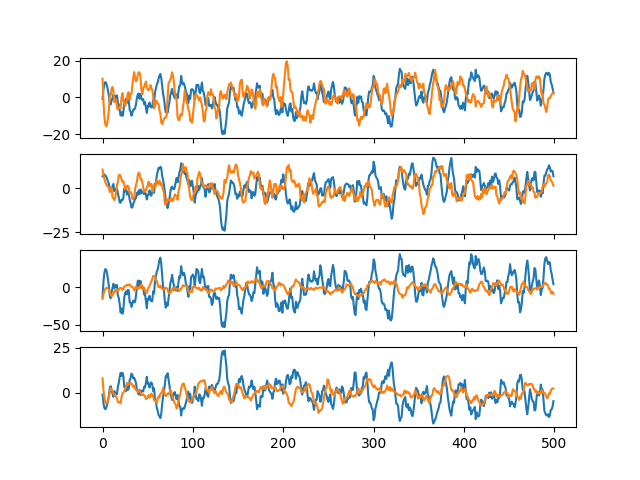

In [185]:
fig, axs = plt.subplots(4, sharex=True)

for ii in range(len(axs)):
    axs[ii].plot(X_projected.cpu()[:500,ii]/5)
    axs[ii].plot(scores[:500,ii])

In [144]:
U.shape

torch.Size([5000, 5000])

<IPython.core.display.Javascript object>


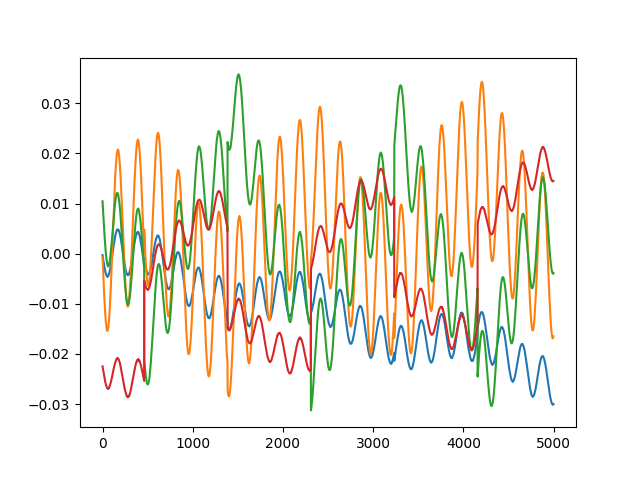

In [165]:
plt.figure()
plt.plot(U.cpu()[:,0:4])

<IPython.core.display.Javascript object>


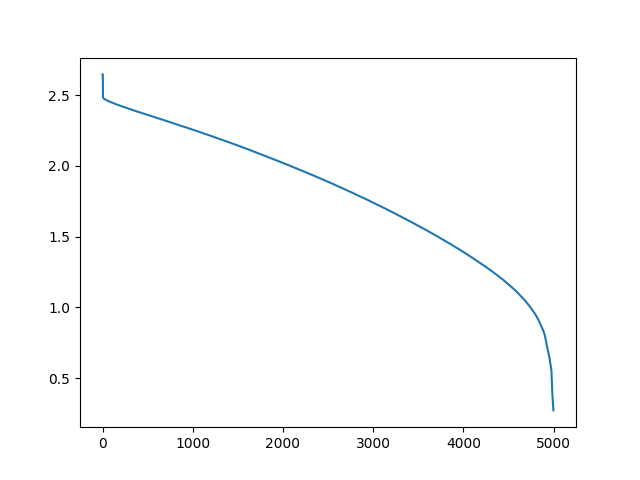

In [166]:
plt.figure()
plt.plot(S.cpu())